# Описание данных

Данные находятся [здесь](https://st.yandex-team.ru/DS-6856).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [ ]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### импорт библиотек
import pandas as pd
import numpy as np
import os
from collections import Counter
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
import random
from math import sqrt, ceil
from nltk.stem import WordNetLemmatizer
import scipy
import re

In [ ]:
### создадим функцию для открытия и просмотра общих сведений
def df_info(name, df):
    display(name)
    display(df.head(3))
    df.info()
    display('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _')

In [ ]:
### откроем и сохраним данные таблиц в переменные
df_train = pd.read_csv('train_dataset.csv')
df_info('df_train', df_train)

test_queries = pd.read_csv('test_queries.csv', error_bad_lines=False, sep='|', index_col=0)
df_info('test_queries', test_queries)

'df_train'

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

<ipython-input-340-502d61c6d088>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_queries = pd.read_csv('test_queries.csv', error_bad_lines=False, sep='|', index_col=0)


'test_queries'

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [ ]:
### откроем и сохраним данные об оценках в переменные
df_crowd = pd.read_csv('CrowdAnnotations.tsv', sep='\t', header=None)
df_info('df_crowd', df_crowd)

df_expert = pd.read_csv('ExpertAnnotations.tsv', sep='\t', header=None)
df_info('df_expert', df_expert)

'df_crowd'

0                            1    2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0  0  3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

'df_expert'

0                            1  2  3  4
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [ ]:
### откроем и сохраним в таблицы информацию о файлах
train_files = [file for file in os.listdir('train_images') if file.endswith('.jpg')]
train_images_df = pd.DataFrame(train_files, columns=['train_file_name'])
df_info('train_images_df', train_images_df)

test_images_df = pd.read_csv('test_images.csv') #, sep='\t', header=None
df_info('test_images_df', test_images_df)

'train_images_df'

train_file_name
0  3609645320_815c294b65.jpg
1  3393343330_b13df4d8ec.jpg
2   566397227_a469e9e415.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   train_file_name  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

'test_images_df'

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Анализ оценок от экспертов и от краудсорсинга

grade
0.000000  41970
0.333333   3000
0.666667   1360
1.000000   1323
0.250000     96
0.500000     27
0.200000     22
0.750000      9
0.600000      8
0.400000      8
0.800000      4
0.166667      3

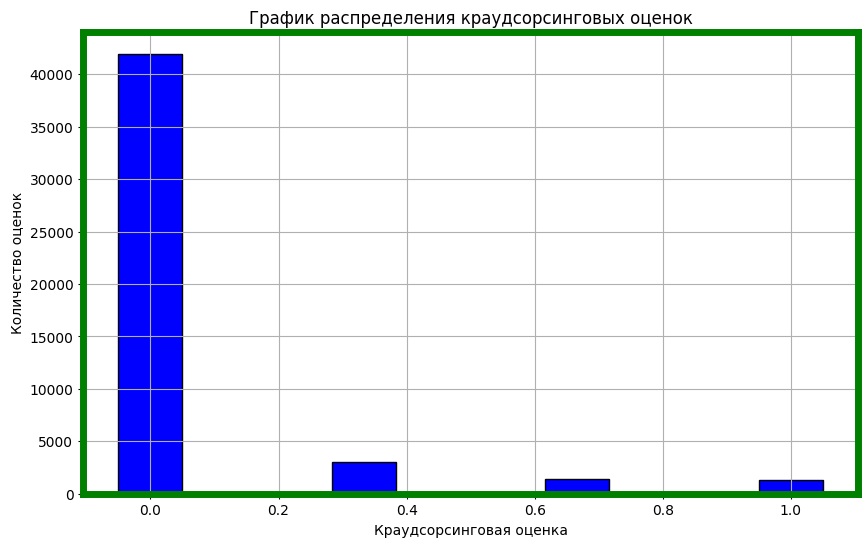

In [ ]:
### построим график распределения оценки от краудсорсингового агенства
df_crowd_plt = pd.DataFrame(df_crowd[2].value_counts())
df_crowd_plt.columns = ['grade']
display(df_crowd_plt)
fig1, ax1 = plt.subplots()
ax1.bar(df_crowd_plt.index, df_crowd_plt.grade, color = 'blue', edgecolor = 'black', width = 0.1)
fig1.set_figwidth(10)
fig1.set_figheight(6)
ax1.set_xlabel('Краудсорсинговая оценка')
ax1.set_ylabel('Количество оценок')
plt.grid()
plt.title('График распределения краудсорсинговых оценок')
plt.show()

In [ ]:
### создадим столбец с итоговой оценкой от экспертов по методу голосования большинства
target_expert = []
for i in range(df_expert.shape[0]):
    labels = df_expert.loc[i, [2,3,4]]
    true_label = Counter(labels).most_common(3)
    if len(list(true_label)) == 3:
        target_expert.append(None)
    else:
        target_expert.append(true_label[0][0])
df_expert['target'] = target_expert
df_expert = df_expert.dropna().reset_index().drop(['index'], axis=1)
df_info('updated_df_expert', df_expert)

'updated_df_expert'

0                            1  2  3  4  target
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1     1.0
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2     1.0
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2     1.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5696 non-null   object 
 1   1       5696 non-null   object 
 2   2       5696 non-null   int64  
 3   3       5696 non-null   int64  
 4   4       5696 non-null   int64  
 5   target  5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 267.1+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [ ]:
### так как оценка должна быть в пределах от 0 до 1, преобразуем столбец target
df_expert['target'] = df_expert['target'].apply(lambda x: (x-1)/3)
df_expert.tail(3)

0                            1  2  3  4    target
5693  997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2  1  1  2  0.000000
5694  997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2  1  1  1  0.000000
5695  997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2  3  3  3  0.666667

target
0.000000    3327
0.333333    1566
0.666667     492
1.000000     311

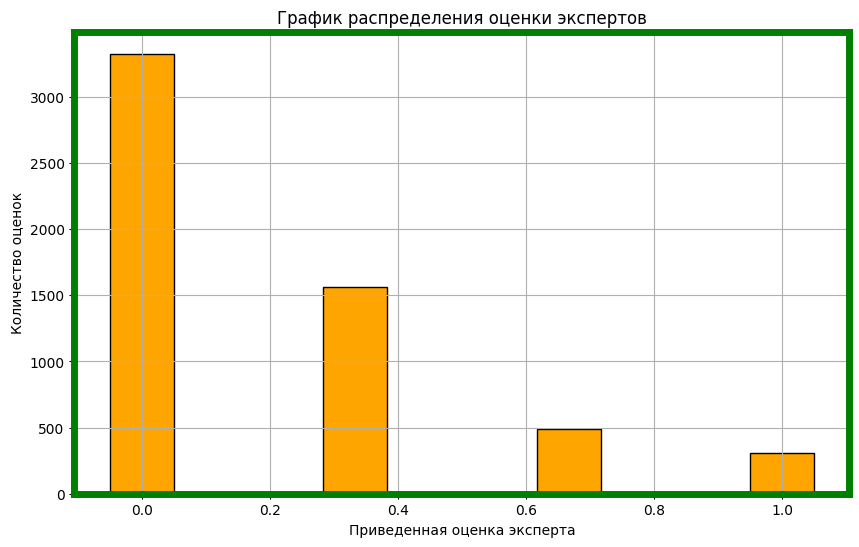

In [ ]:
### построим график распределения оценки экспертов
df_expert_plt = pd.DataFrame(df_expert['target'].value_counts())
df_expert_plt.columns = ['target']
display(df_expert_plt)
fig2, ax2 = plt.subplots()
ax2.bar(df_expert_plt.index, df_expert_plt.target, color = 'orange', edgecolor = 'black', width = 0.1)
fig2.set_figwidth(10)
fig2.set_figheight(6)
ax2.set_xlabel('Приведенная оценка эксперта')
ax2.set_ylabel('Количество оценок')
plt.grid()
plt.title('График распределения оценки экспертов')
plt.show()

In [ ]:
### объединим все оценки в таблице temp_data
df_expert.columns = ['image', 'query_id', 'exp1', 'exp2', 'exp3', 'target']
df_crowd.columns = ['image', 'query_id', 'rate', 'conf', 'noconf']
temp_data = df_train.merge(df_expert[['image', 'query_id', 'target']], how='left', on=['image', 'query_id'])\
                    .merge(df_crowd[['image', 'query_id', 'rate']], how='outer', on=['image', 'query_id'])

temp_data['target'] = temp_data['target'].apply(lambda x: x*0.6)
temp_data['rate'] = temp_data['rate'].apply(lambda x: x*0.4).fillna(0)
temp_data['total'] = temp_data.target + temp_data.rate
temp_data = temp_data.dropna()
temp_data = temp_data[['image', 'query_id', 'query_text', 'total']]
display(temp_data.tail())

image                     query_id  \
5817  757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818  799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819  909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820  929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821  968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                        query_text     total  
5817    A man in an ampitheater talking to a boy .  0.333333  
5818     a old man walks down the uncrowded road .  0.000000  
5819  A dog stands on the side of a grassy cliff .  0.200000  
5820                  A blurry photo of two dogs .  0.400000  
5821                   A man rows his boat below .  0.000000

total
0.000000   3322
0.200000   1461
0.400000    232
1.000000    224
0.533333    142
0.333333     79
0.666667     73
0.866667     62
0.800000     35
0.733333     18
0.466667     18
0.600000     11
0.133333      4
0.500000      2
0.280000      2
0.300000      2
0.700000      2
0.560000      2
0.720000      2
0.400000      2
0.100000      1

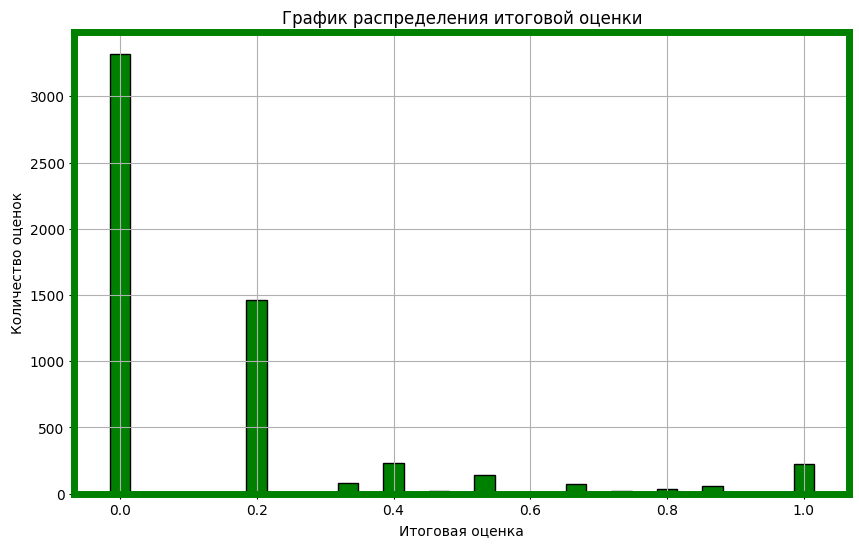

In [ ]:
### построим график распределения итоговой оценки
temp_data_plt = pd.DataFrame(temp_data['total'].value_counts())
temp_data_plt.columns = ['total']
display(temp_data_plt)
fig3, ax3 = plt.subplots()
ax3.bar(temp_data_plt.index, temp_data_plt.total, color = 'green', edgecolor = 'black', width = 0.03)
fig3.set_figwidth(10)
fig3.set_figheight(6)
ax3.set_xlabel('Итоговая оценка')
ax3.set_ylabel('Количество оценок')
plt.grid()
plt.title('График распределения итоговой оценки')
plt.show()

### Анализ фотографий

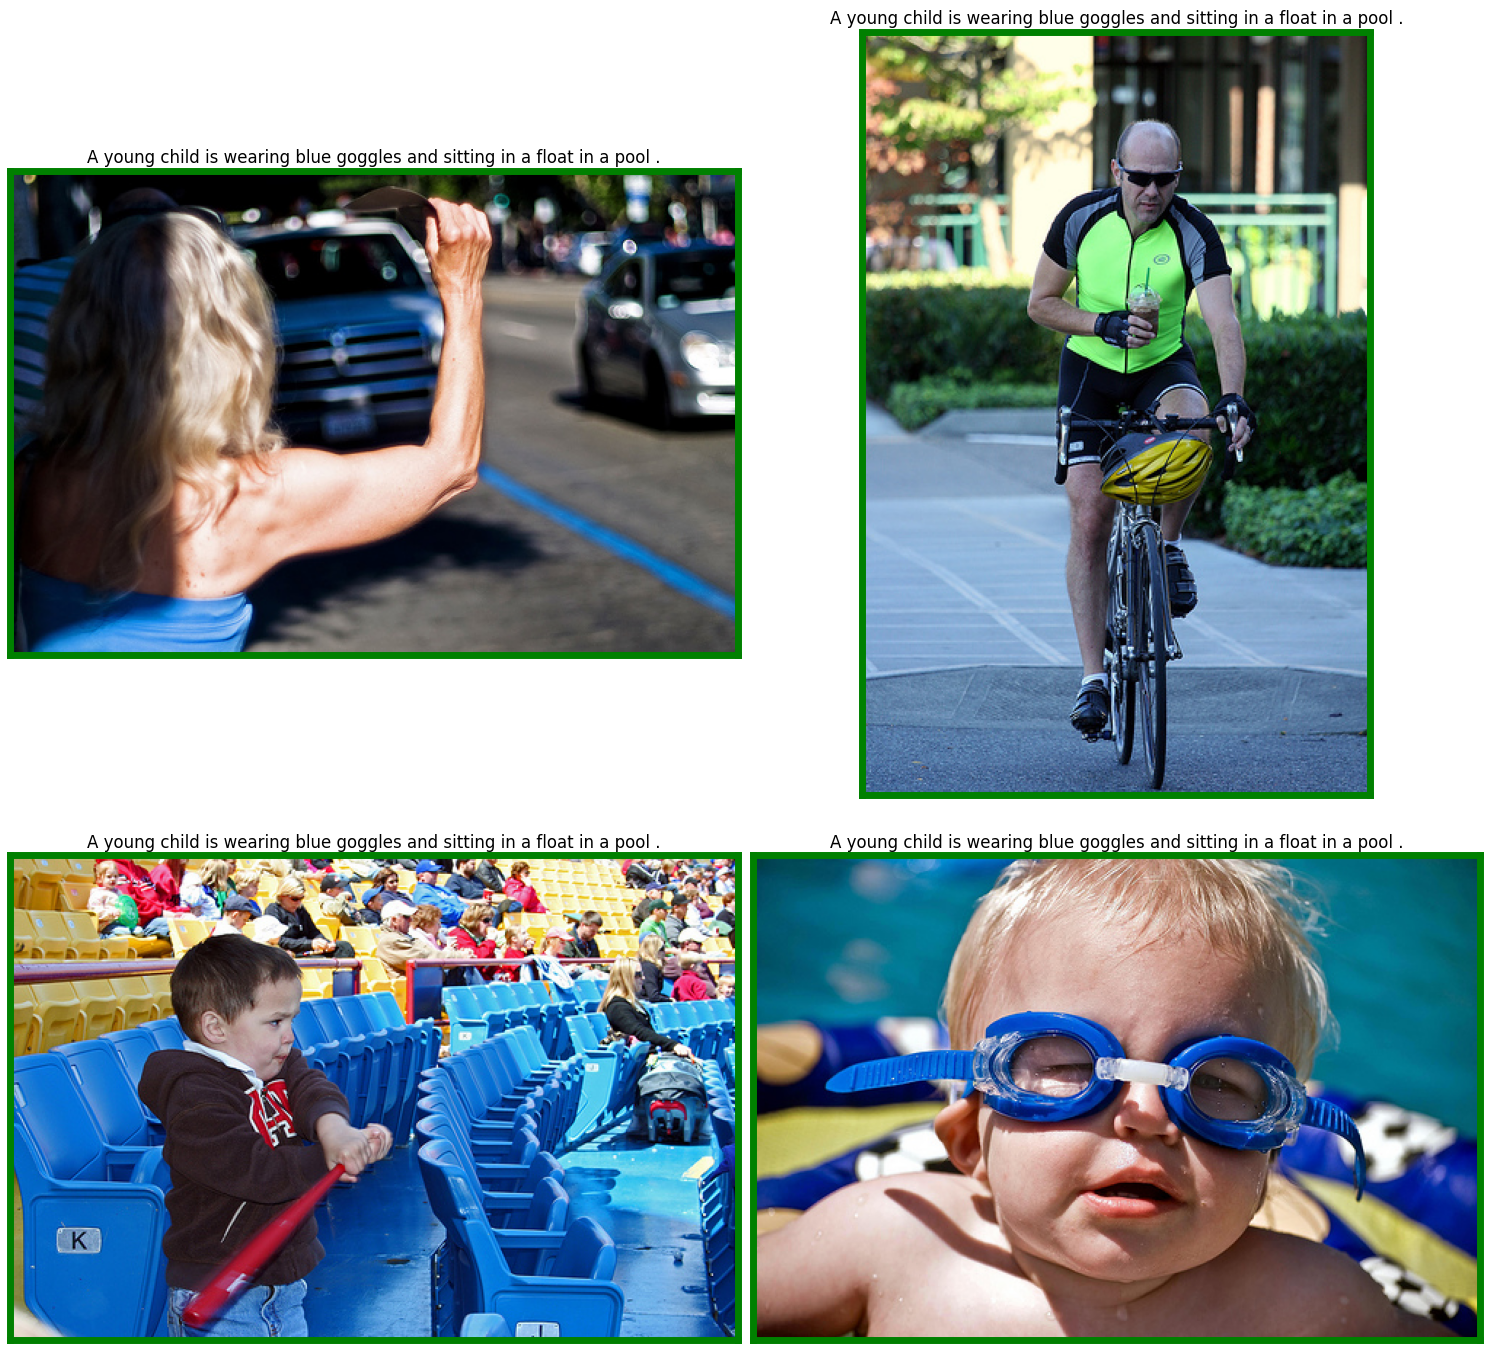

In [ ]:
### примеры фотографий обучающей выборки с описанием
df_train_image_name = df_train[['image']].squeeze().tolist()
df_train_query_text = df_train[['query_text']].squeeze().tolist()
fig = plt.figure(figsize=(15,15))
for i in range(4):
    fig.add_subplot(2, 2, i+1)
    img = Image.open(f'train_images/{df_train_image_name[i]}')
    plt.imshow(img)
    plt.title(df_train_query_text[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

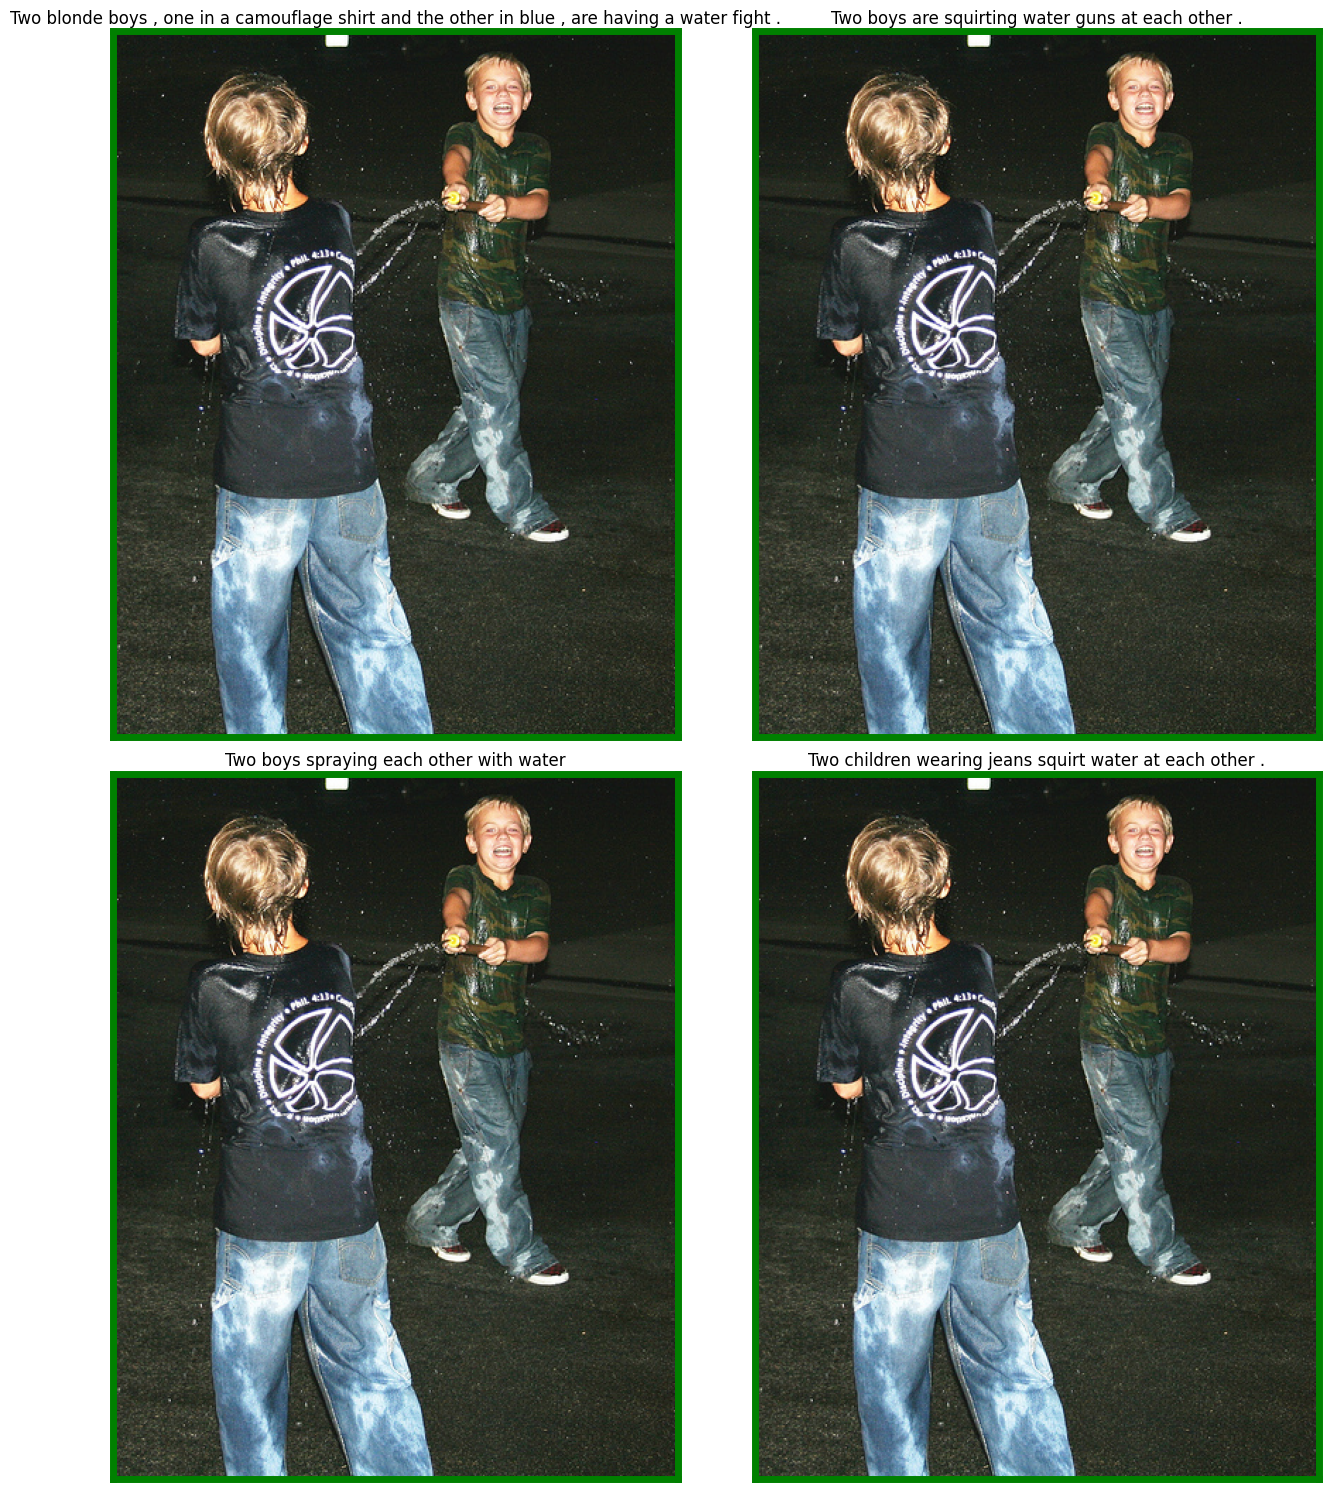

In [ ]:
### примеры фотографий тестовой выборки с описанием
test_queries_image_name = test_queries[['image']].squeeze().tolist()
test_queries_query_text = test_queries[['query_text']].squeeze().tolist()
fig = plt.figure(figsize=(15,15))
for i in range(4):
    fig.add_subplot(2, 2, i+1)
    img = Image.open(f'test_images/{test_queries_image_name[i]}')
    plt.imshow(img)
    plt.title(test_queries_query_text[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
### создадим список запрещенных слов
poc_stop_words = ['child', 'kid', 'boy', 'teenager', 'girl', 'baby', 'children',
                  'young', 'teen', 'youth', 'junior', 'toddler', 'minor']
### обозначим корпус текстов для лемматизации
corpus = pd.DataFrame(temp_data['query_text'])
### скачаем требующиеся пакеты
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
### напишем функцию для лемматизации и применим к корпусу
def func_lemmatize(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    text = nltk.word_tokenize(text)
    text = [lemmatizer.lemmatize(words) for words in text]
    return text
corpus['lemm_query_text'] = corpus['query_text'].apply(func_lemmatize)
# corpus.columns = ['lemm_query_text']
display(corpus.tail(3))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


query_text  \
5819  A dog stands on the side of a grassy cliff .   
5820                  A blurry photo of two dogs .   
5821                   A man rows his boat below .   

                                        lemm_query_text  
5819  [a, dog, stand, on, the, side, of, a, grassy, ...  
5820                   [a, blurry, photo, of, two, dog]  
5821                    [a, man, row, his, boat, below]

In [ ]:
### напишем функцию проверки на запрещенные слова и применим к корпусу
def is_forbidden(text):
    text = ' '.join(text)
    for i in poc_stop_words:
        if text.find(i) != -1:
            return 1
    return 0
corpus['is_forbidden'] = corpus['lemm_query_text'].apply(is_forbidden)
### сделаем срез для сбора всех уникальных корпусов текстов
forbidden_corpus = corpus.query('is_forbidden == 1')[['query_text', 'is_forbidden']].drop_duplicates()
### выведем получившееся
forbidden_corpus.shape[0]

308

In [ ]:
### удалим полученные данные из тренировочной выборки
temp_data['lemm_query_text'] = temp_data['query_text'].apply(func_lemmatize)
temp_data = temp_data.merge(forbidden_corpus, left_on='query_text', right_on='query_text', how='outer')
temp_data = temp_data[temp_data['is_forbidden'] != 1][['image', 'query_id', 'query_text', 'total', 'lemm_query_text']]
display(temp_data.tail(3))

image                     query_id  \
5693  909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5694  929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5695  968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                        query_text  total  \
5693  A dog stands on the side of a grassy cliff .    0.2   
5694                  A blurry photo of two dogs .    0.4   
5695                   A man rows his boat below .    0.0   

                                        lemm_query_text  
5693  [a, dog, stand, on, the, side, of, a, grassy, ...  
5694                   [a, blurry, photo, of, two, dog]  
5695                    [a, man, row, his, boat, below]

In [ ]:
### лемматизируем текст для тестовой выборки
# test_queries['lemm_query_text'] = test_queries['query_text'].apply(lemmatize)
# test_queries = test_queries[['query_id', 'image', 'lemm_query_text']]
# display(test_queries.tail(3))

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
### используем нейросеть с архитектурой ResNet-50
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad_(False)

display(list(resnet.children()))
### оставим предпоследний слой для уменьшения размерности тензора
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
### приведение изображения к верному формату
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm])

In [ ]:
### проверка работы сети на одном изображении
img = Image.open('train_images/1056338697_4f7d7ce270.jpg').convert('RGB')
image_tensor = preprocess(img)
output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
output_tensor.size()

torch.Size([2048])

In [ ]:
%%time
tqdm.pandas()
### напишем функцию векторизации и получим массив данных для обучающей выборки
def train_data_img_vect(row):
    img = Image.open(path+row['image']).convert('RGB')
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    output_tensor.size()
    return output_tensor.numpy()
path = 'train_images/'
train_array = np.array(temp_data.progress_apply(train_data_img_vect, axis=1))
display(train_array)

  0%|          | 0/4077 [00:00<?, ?it/s]

array([array([0.02304389, 0.9211398 , 0.03865412, ..., 0.13604723, 0.17499219,
              0.25573826], dtype=float32)                                     ,
       array([0.02025634, 0.7552836 , 0.35721478, ..., 0.06598956, 0.21601583,
              0.16012865], dtype=float32)                                     ,
       array([0.29022074, 0.6701441 , 0.08618802, ..., 0.07450119, 0.07059103,
              0.3274662 ], dtype=float32)                                     ,
       ...,
       array([0.39926144, 0.5591697 , 0.92089665, ..., 0.52559793, 0.72624487,
              0.15461753], dtype=float32)                                     ,
       array([0.19873741, 0.90317404, 1.9932746 , ..., 0.43494233, 0.26616427,
              0.21728075], dtype=float32)                                     ,
       array([0.12715793, 0.6590405 , 0.46013626, ..., 0.11723436, 0.50723654,
              0.13837881], dtype=float32)                                     ],
      dtype=object)

CPU times: user 14min 57s, sys: 3.79 s, total: 15min 1s
Wall time: 15min 37s


## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [ ]:
### векторизируем текст из обучающей выборки
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))
def union(text):
    text = ' '.join(text)
    return text
corpus_train = temp_data['lemm_query_text']
corpus_train = corpus_train.apply(union)

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
display('Размер матрицы для обучающей выборки:', tf_idf_train.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'Размер матрицы для обучающей выборки:'

(4077, 1009)

In [ ]:
### векторизируем текст из тестовой выборки
# corpus_test = test_queries['lemm_query_text']
# tf_idf_test = count_tf_idf.transform(corpus_test)
# display('Размер матрицы для тестовой выборки:', tf_idf_test.shape)

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
### объединим признаки в одну таблицу
data_for_train = np.hstack([np.vstack(train_array), tf_idf_train.toarray()])
#data_for_train = pd.DataFrame(data_for_train, index=temp_data.index)
display(data_for_train.shape)

(4077, 3057)

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Так как в проекте хотим получить вероятность, то есть перед нами стоит задача регрессии, а не поиск класса или множество классов, оптимальным будет выбор между метриками МАЕ и RMSE. Примем метрику RMSE.

In [ ]:
### подготовим данные
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, valid_indices = next(gss.split(X=data_for_train, y=temp_data['total'], groups=temp_data['image']))
# train_df, test_df = temp_data.loc[train_indices], temp_data.loc[test_indices]
features_train = pd.DataFrame(data_for_train).loc[train_indices]
features_valid = pd.DataFrame(data_for_train).loc[valid_indices]
target_train = (temp_data['total'].reset_index(drop=True)).loc[train_indices]
target_valid = (temp_data['total'].reset_index(drop=True)).loc[valid_indices]
display(features_train.shape)
display(features_valid.shape)
display(target_train.shape)
display(target_valid.shape)

(2885, 3057)

(1192, 3057)

(2885,)

(1192,)

### Линейная регрессия

In [ ]:
%%time
### обучим модель LinearRegression для расчета RMSE
lin_reg = LinearRegression(positive=True)
lin_reg.fit(features_train, target_train)
predictions = lin_reg.predict(features_valid)
score = mean_squared_error(target_valid, predictions) ** 0.5
display("RMSE модели линейной регрессии составляет:", score)

'RMSE модели линейной регрессии составляет:'

0.28018512107147786

CPU times: user 27.4 s, sys: 373 ms, total: 27.7 s
Wall time: 27.8 s


### Полносвязная нейронная сеть

In [ ]:
### преобразуем в тензоры
X_train = torch.FloatTensor(features_train.values)
X_test = torch.FloatTensor(features_valid.values)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_valid.values)
### выведем размерности тензоров на экран
display('X_train', X_train.shape)
display('X_test', X_test.shape)
display('y_train', y_train.shape)
display('y_test', y_test.shape)

'X_train'

torch.Size([2885, 3057])

'X_test'

torch.Size([1192, 3057])

'y_train'

torch.Size([2885])

'y_test'

torch.Size([1192])

In [ ]:
### зафиксируем рандом, для повторяемости результатов
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
### определим количество нейронов для базовой модели
n_in_neurons = int(X_train.shape[1])
n_hidden_neurons_1 = 1024
n_hidden_neurons_2 = 512
n_hidden_neurons_3 = 512
n_hidden_neurons_4 = 512
n_hidden_neurons_5 = 2
n_out_neurons = 1
### выведем на экран
display(f'Количество нейронов на входном слое: {n_in_neurons}')
display(f'Количество нейронов на первом скрытом слое: {n_hidden_neurons_1}')
display(f'Количество нейронов на втором скрытом слое: {n_hidden_neurons_2}')
display(f'Количество нейронов на третьем скрытом слое: {n_hidden_neurons_3}')
display(f'Количество нейронов на четвертом скрытом слое: {n_hidden_neurons_4}')
display(f'Количество нейронов на пятом скрытом слое: {n_hidden_neurons_5}')
display(f'Количество нейронов на выходе: {n_out_neurons}')

'Количество нейронов на входном слое: 3057'

'Количество нейронов на первом скрытом слое: 1024'

'Количество нейронов на втором скрытом слое: 512'

'Количество нейронов на третьем скрытом слое: 512'

'Количество нейронов на четвертом скрытом слое: 512'

'Количество нейронов на пятом скрытом слое: 2'

'Количество нейронов на выходе: 1'

In [ ]:
%%time
### архитектура сети с пятью скрытыми слоями
class Model_base(nn.Module):
    def __init__(self, neurons_hid1, neurons_hid2, neurons_hid3, neurons_hid4, neurons_hid5, activation_1, activation_2):
        super(Model_base, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = activation_1
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation_1
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = activation_2
        self.layer4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = activation_2
        self.layer5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)
        self.act5 = activation_2
        self.layer6 = nn.Linear(n_hidden_neurons_5, 1)
        self.act6 = nn.Sigmoid()

        nn.init.kaiming_uniform_(self.layer1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer5.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer6.weight, mode='fan_in', nonlinearity='sigmoid')

    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.layer3(x)
        x = self.act3(x)
        x = self.layer4(x)
        x = self.act4(x)
        x = self.layer5(x)
        x = self.act5(x)
        x = self.layer6(x)
        x = self.act6(x)
        return x

### инициализация модели
model_first = Model_base(n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                         n_hidden_neurons_4, n_hidden_neurons_5, nn.ReLU(), nn.ReLU())

### добавление оптимизатора adam
optimizer = torch.optim.Adam(model_first.parameters(), lr=0.00001)
### добаавление функции потерь
loss = nn.MSELoss()
### количество эпох
num_epochs = 11
### размер батча
batch_size = 50
### количество батчей
num_batches = ceil(len(X_train)/batch_size)
### переменная для сравнения с предварительным результатом
best_rmse = score
### инициализация сети
for epoch in tqdm(range(num_epochs)):
    order = np.random.permutation(len(X_train))
### создаем случайную перестановку индексов объектов
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
### посчитаем номер стартового объекта батча
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
### извлеките индексы объектов текущего обатча
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = model_first.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()
### расчет метрики для сотой и последней эпохи
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            model_first.eval()
            test_preds = model_first.forward(X_test)
            rmse = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
            display(f'epoch:{epoch}, rmse:{rmse}, best_rmse:{best_rmse}')
### запись промежуточного результата для получения наилучшего значения
        if rmse < best_rmse:
            best_rmse = rmse
### вывод лучшей метрики на экран
display('Лучшее значение RMSE:', round(best_rmse, 5))

  0%|          | 0/11 [00:00<?, ?it/s]

'epoch:0, rmse:0.43613296898285125, best_rmse:0.28018512107147786'

'epoch:0, rmse:0.41318918295145224, best_rmse:0.28018512107147786'

'epoch:0, rmse:0.38717164386613206, best_rmse:0.28018512107147786'

'epoch:0, rmse:0.359697073205044, best_rmse:0.28018512107147786'

'epoch:0, rmse:0.3334967528039276, best_rmse:0.28018512107147786'

'epoch:0, rmse:0.31084047989176455, best_rmse:0.28018512107147786'

'epoch:0, rmse:0.29234245750594157, best_rmse:0.28018512107147786'

'epoch:0, rmse:0.27886804591510456, best_rmse:0.28018512107147786'

'epoch:0, rmse:0.2692226772055121, best_rmse:0.27886804591510456'

'epoch:0, rmse:0.263068080032669, best_rmse:0.2692226772055121'

'epoch:0, rmse:0.25932810083618896, best_rmse:0.263068080032669'

'epoch:0, rmse:0.25748442959236545, best_rmse:0.25932810083618896'

'epoch:0, rmse:0.256931127741545, best_rmse:0.25748442959236545'

'epoch:0, rmse:0.25714123642359604, best_rmse:0.256931127741545'

'epoch:0, rmse:0.25775314861653664, best_rmse:0.256931127741545'

'epoch:0, rmse:0.25863171958490766, best_rmse:0.256931127741545'

'epoch:0, rmse:0.25955900421654365, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2604184087059247, best_rmse:0.256931127741545'

'epoch:0, rmse:0.26122005834068135, best_rmse:0.256931127741545'

'epoch:0, rmse:0.26197719623792876, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2626328234462757, best_rmse:0.256931127741545'

'epoch:0, rmse:0.26311445301147873, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2635164155787063, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2637579600773658, best_rmse:0.256931127741545'

'epoch:0, rmse:0.26380782684420306, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2637223089515687, best_rmse:0.256931127741545'

'epoch:0, rmse:0.26355174118256397, best_rmse:0.256931127741545'

'epoch:0, rmse:0.26324327744035986, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2628587831028969, best_rmse:0.256931127741545'

'epoch:0, rmse:0.26235487479818603, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2616330760961431, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2608993142563466, best_rmse:0.256931127741545'

'epoch:0, rmse:0.26012069413353106, best_rmse:0.256931127741545'

'epoch:0, rmse:0.25927313389925455, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2583205967244976, best_rmse:0.256931127741545'

'epoch:0, rmse:0.25739078999735615, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2565049914772281, best_rmse:0.256931127741545'

'epoch:0, rmse:0.2557057072095038, best_rmse:0.2565049914772281'

'epoch:0, rmse:0.2549605707698082, best_rmse:0.2557057072095038'

'epoch:0, rmse:0.25427568408902923, best_rmse:0.2549605707698082'

'epoch:0, rmse:0.25368827853725956, best_rmse:0.25427568408902923'

'epoch:0, rmse:0.25317226839826623, best_rmse:0.25368827853725956'

'epoch:0, rmse:0.25273205610151855, best_rmse:0.25317226839826623'

'epoch:0, rmse:0.2523743855920939, best_rmse:0.25273205610151855'

'epoch:0, rmse:0.2521695826238529, best_rmse:0.2523743855920939'

'epoch:0, rmse:0.2520738209093509, best_rmse:0.2521695826238529'

'epoch:0, rmse:0.2521365924538032, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.2523610265622382, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.2527379373243346, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.2533553676423578, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.2539905114842112, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.2545984223577235, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.25508546628800727, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.2558806315903221, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.25621001408453165, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.2562059864764493, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.2557935557262781, best_rmse:0.2520738209093509'

'epoch:0, rmse:0.25502220814431986, best_rmse:0.2520738209093509'

'epoch:10, rmse:0.24662478992136125, best_rmse:0.2520738209093509'

'epoch:10, rmse:0.24677434541294502, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24733566087808342, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24768904159012256, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.247964417276106, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24840909687560353, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24881698427756463, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24931543471807882, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24929378270903527, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24899278339878309, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24883968829440586, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24846897105851365, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.2483119674439748, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.2481837758419119, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24865684453066889, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.2483858285707074, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24874568483788737, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24905117104872868, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24943055178294524, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24957250015272012, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.25020711485327557, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.25070075825982446, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.2512433604411696, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.2515192954357304, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.25116290881822734, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.25051003820803747, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24972911404386652, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24895037907033127, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24843370506699072, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24767106791068702, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24734891480037582, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.2470399212144761, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.24670675918982313, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.2464848921901881, best_rmse:0.24662478992136125'

'epoch:10, rmse:0.2463540184404977, best_rmse:0.2464848921901881'

'epoch:10, rmse:0.24627826222298038, best_rmse:0.2463540184404977'

'epoch:10, rmse:0.24631881261923833, best_rmse:0.24627826222298038'

'epoch:10, rmse:0.2463547896457293, best_rmse:0.24627826222298038'

'epoch:10, rmse:0.24633335377775253, best_rmse:0.24627826222298038'

'epoch:10, rmse:0.24632626100579577, best_rmse:0.24627826222298038'

'epoch:10, rmse:0.2462610327117776, best_rmse:0.24627826222298038'

'epoch:10, rmse:0.24629673836202182, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.24656669644554616, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.24694117461955692, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.2474751980954657, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.24777129777215648, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.24782131482450134, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.24826256693122753, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.24894941389128258, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.2502958960628006, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.251771624935696, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.25290874261922786, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.25395652566683175, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.25386950887266435, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.2537124481038735, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.2531555963791981, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.25231199802899645, best_rmse:0.2462610327117776'

'epoch:10, rmse:0.2522428606145861, best_rmse:0.2462610327117776'

'Лучшее значение RMSE:'

0.24626

CPU times: user 52.5 s, sys: 165 ms, total: 52.7 s
Wall time: 53.1 s


### Вывод

В результате обучения моделей получены следующие значения метрики RMSE:
- Для линейной регрессии 0.281
- Для полносвязной нейронной сети с 5 скрытыми слоями 0.246
В целом метрики схожи и отличаются незначительно.
Для теста примем модель с наименьшей метрикой - полносвязную нейронную сеть.

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
%%time
### преобразуем тестовые изображения
tqdm.pandas()
### напишем функцию векторизации и получим массив данных для тестовой выборки
def test_data_img_vect(row):
    img = Image.open(path_test+row['image']).convert('RGB')
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    output_tensor.size()
    return output_tensor.numpy()
path_test = 'test_images/'
test_vect_img = torch.tensor(test_images_df.progress_apply(test_data_img_vect, axis=1))
display(test_vect_img.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2048])

CPU times: user 22.9 s, sys: 125 ms, total: 23 s
Wall time: 25.1 s


In [ ]:
### напишем функцию расчета вероятности и вывода наиболее подходящих картинок и текста описания
def prob_img(text) -> None:

    if [i for i in func_lemmatize(text) if i in poc_stop_words]: ### проверка на наличие запрещенных слов
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        text_vect = count_tf_idf.transform([text]) ### получим вектора текстов
### объединяем вектора тестовых изображений с векторами текстов
        X = np.concatenate((
            test_vect_img,
            np.resize(text_vect.toarray(), (test_vect_img.shape[0],tf_idf_train.shape[1]))),
            axis=1)
        X = np.float32(X)
        X = torch.from_numpy(X)
        model_first.eval()
        predictions = model_first.forward(X) ### получаем предсказания
        df = pd.concat((test_images_df, pd.Series(np.reshape(predictions.detach().numpy(), (predictions.shape[0],)), name='pred')), axis=1) ### вывод оценок
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5)) ### топ 5 названия картинок
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5)) ### топ 5 оценки

        print('')
        print('-' * 20, text, '-' * 20)
        print('')
### вывод на экран 4 наиболее похожих изображения
        fig = plt.figure(figsize=(15,5))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(f'test_images/{top[i]}')
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
### проверка был ли текст был в исходном файле с описаниями, если да то вывод ее на экран
        if text in list(test_queries['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            img_temp = test_queries.iloc[test_queries[test_queries['query_text'] == text].index[0]]['image']
            image = Image.open(f'test_images/{img_temp}')
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        plt.show()

    return None


In [ ]:
### получение выборки из 10 описаний
random_test_queries = test_queries.sample(10, random_state=42)
text_test = list(random_test_queries['query_text'])
text_test

['A group of girls who are gothically dressed standing together',
 'A woman and girl riding downhill on a sled with a dog running alongside them',
 'The dog is running .',
 'A group of people are ice skating in a big city .',
 'Little kid in blue coat and hat riding a tricycle .',
 'Two black dogs fighting over an orange toy .',
 'A dog jumping for a tennis ball near an ocean',
 'Boy flying a distant kite .',
 'kids play ultimate Frisbee .',
 'A girl in a purple shirt feeding ducks']


-------------------- A group of girls who are gothically dressed standing together --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- A woman and girl riding downhill on a sled with a dog running alongside them --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- The dog is running . --------------------



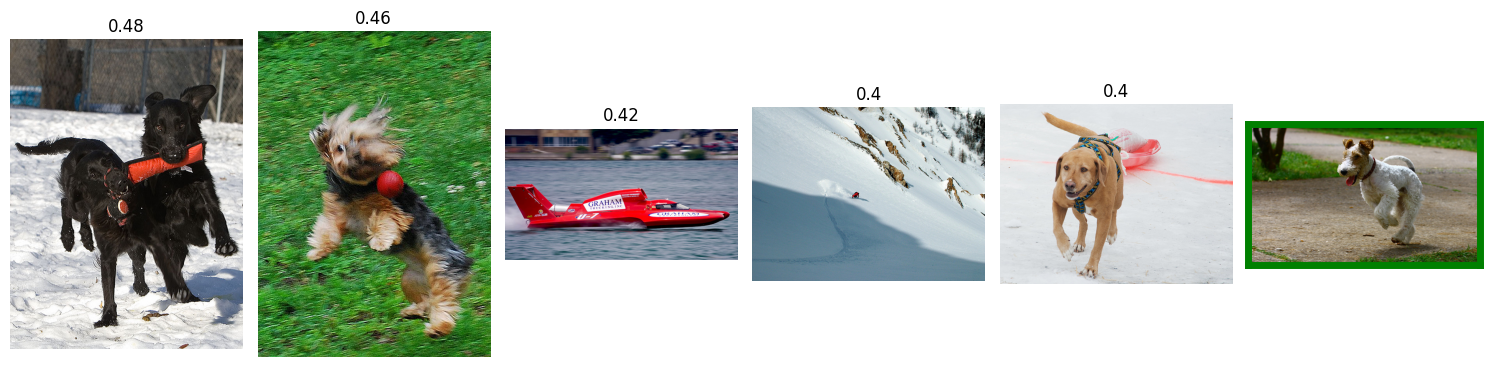


-------------------- A group of people are ice skating in a big city . --------------------



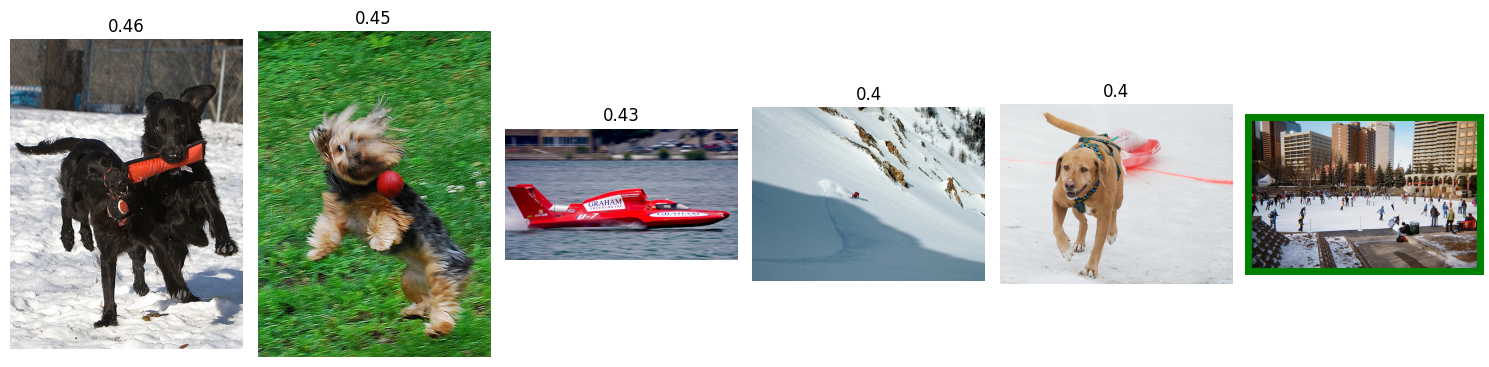


-------------------- Little kid in blue coat and hat riding a tricycle . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- Two black dogs fighting over an orange toy . --------------------



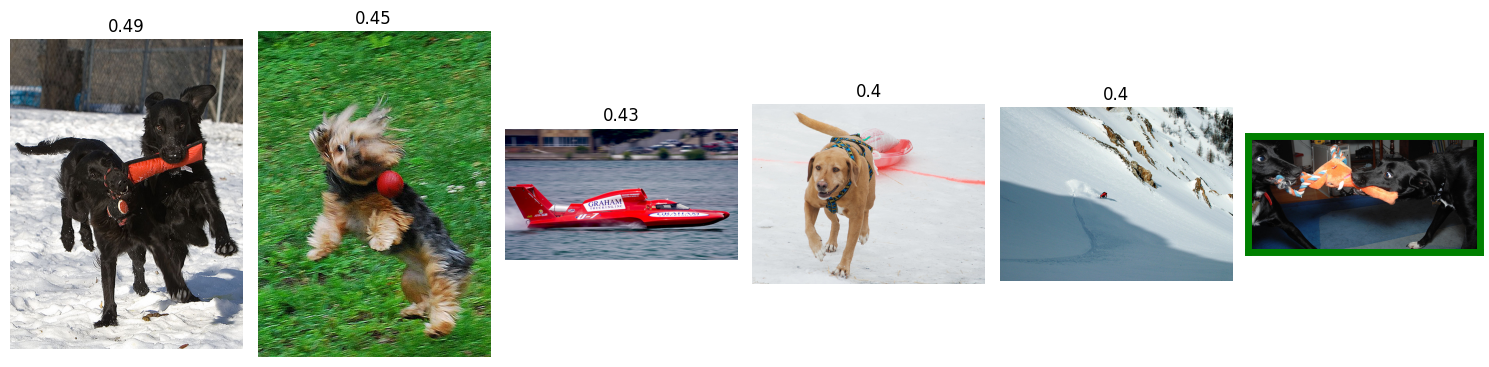


-------------------- A dog jumping for a tennis ball near an ocean --------------------



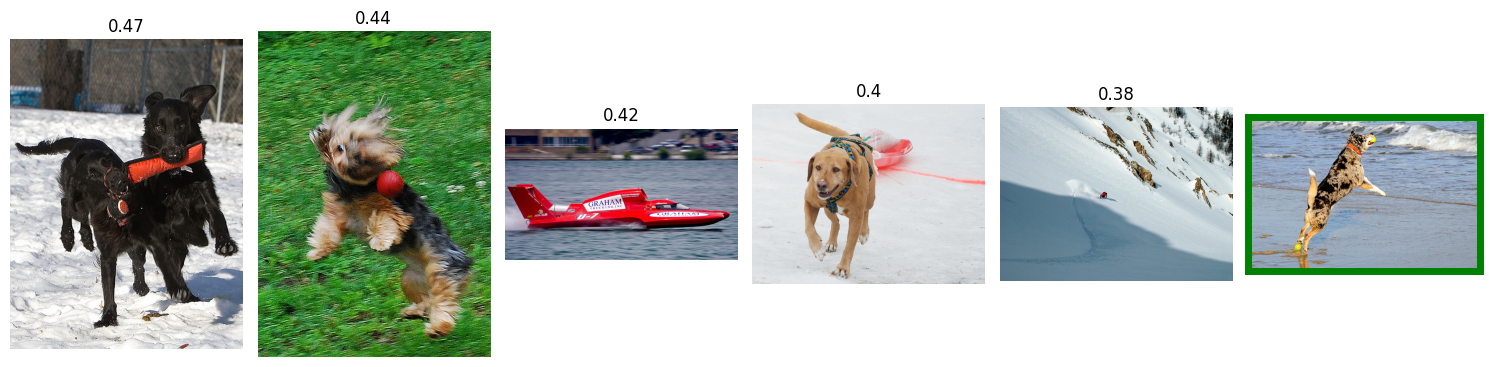


-------------------- Boy flying a distant kite . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- kids play ultimate Frisbee . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- A girl in a purple shirt feeding ducks --------------------

This image is unavailable in your country in compliance with local laws.



In [ ]:
### получение результата работы функции
for text in text_test:
    prob_img(text)